<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 図書館

In [1]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import geocoder
import math
import io
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

def number_to_kanji(str):
    return str.translate(str.maketrans({
        '１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九',
        '1':'一', '2':'二', '3':'三', '4':'四', '5':'五', '6':'六', '7':'七', '8':'八', '9':'九', '0':'十', 
    }))

# 緯度経度取得
def add_lat_lon(df_master):
    lats = []
    lons = []
    for i, row in df_master.iterrows():
        chocho = number_to_kanji(row['町丁目'])
        ret = geocoder.osm('東京都' + row['市区町村名'] + chocho, timeout=5)
        if not ret.ok:
            print(i, row['市区町村名'], chocho)
        lats.append(ret.lat)
        lons.append(ret.lng)
    df_copy = df_master.copy()
    df_copy['緯度'] = lats
    df_copy['経度'] = lons
    return df_copy

# def add_pref_district(df_data, district, is_master=False):
#     df_data['都道府県'] = '東京都'
#     df_data['市区町村'] = district
#     if is_master:
#         df_data['町丁目'] = df_data['町丁目'].apply(number_to_kanji)
#         df_data['町名'] = df_data['町丁目'].str.replace('[一二三四五六七八九十]丁目', '', regex=True)

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [6]:
extract_columns = ['施設分類', '施設名', '市区町村名', '所在地', '緯度', '経度']

## 0. 東京都
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t000003d0000000033/resource/27d1ce20-9023-4690-944c-5da47ed1427e)
- [図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t000021d2000000003/resource/7108f0a3-0257-424a-9722-e84999a01392)

## 1. 千代田区

## 2. 中央区
- [区立図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131024d0000000009/resource/000f73eb-36ec-46a3-af45-345602281d1d)

## 3. 港区
- [港区の公共施設情報](https://catalog.data.metro.tokyo.lg.jp/dataset/t131032d0000000014)

In [7]:
minato_library_url = 'https://opendata.city.minato.tokyo.jp/dataset/52105970-c407-423c-8827-2cfc229bf864/resource/dc824430-1645-45f6-8dc1-229b2d2c97a2/download/minatokushisetsujoho_tosyokan.csv'
df_minato_library = get_data_csv_url(minato_library_url)
df_minato_library['市区町村名'] = '港区'
df_minato_library = df_minato_library[df_minato_library['第2分類'] == '図書館'].reset_index(drop=False)
df_minato_library = df_minato_library.rename(columns={'第2分類':'施設分類', 'ページタイトル':'施設名'})[extract_columns]
print(df_minato_library.shape)

(7, 6)


## 4. 新宿区

## 5. 文京区
- [区立図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131059d0313060001/resource/7479e54e-2afb-4598-83dc-5a258c9f9c68)

## 6. 台東区
- [図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000090/resource/642d35ad-56fa-4d9f-b364-45aa615da5a6)

In [8]:
taito_library_url = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_12.csv'
df_taito_library = get_data_csv_url(taito_library_url, 'shift-jis')
df_taito_library['市区町村名'] = '台東区'
df_taito_library['施設分類'] = '図書館'
df_taito_library = df_taito_library.rename(columns={'名称':'施設名', 'X座標':'経度', 'Y座標':'緯度'})[extract_columns]
print(df_taito_library.shape)

(8, 6)


## 7. 墨田区

In [9]:
sumida_library_url = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/library.csv'
df_sumida_library = get_data_csv_url(sumida_library_url, 'shift-jis')
df_sumida_library['市区町村名'] = '墨田区'
df_sumida_library['施設分類'] = '図書館'
df_sumida_library = df_sumida_library.rename(columns={'施設名称':'施設名'})[extract_columns]
print(df_sumida_library.shape)

(7, 6)


## 8. 江東区

## 9. 品川区

## 10. 目黒区

## 11. 大田区
- [図書館一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131113d0000000021/resource/b73e2be9-5f66-4539-9449-e2b2e3d06f31)

## 12. 世田谷区

## 13. 渋谷区

## 14. 中野区

## 15. 杉並区

## 16. 豊島区

## 17. 北区

## 18. 荒川区

## 19. 板橋区
- [板橋区の図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000001381/resource/81734445-ec05-47c7-9fa4-0495af2d030a)

## 20. 練馬区

In [10]:
nerima_library_url = 'https://www.city.nerima.tokyo.jp/kusei/tokei/opendata/opendatasite/sisetsujyouhou/toshokan.files/toshokan.csv'
df_nerima_library = get_data_csv_url(nerima_library_url, 'shift-jis')
df_nerima_library['市区町村名'] = '練馬区'
df_nerima_library = df_nerima_library[~df_nerima_library['名称'].str.contains('受取窓口')].reset_index(drop=True)
df_nerima_library['施設分類'] = '図書館'
df_nerima_library = df_nerima_library.rename(columns={'名称':'施設名'})[extract_columns]
print(df_nerima_library.shape)

(13, 6)


## 21. 足立区

## 22. 葛飾区

## 23. 江戸川区

## 図書館マスタ

|No.|区名|データ|
|:----|:----|:----|
|0|東京都| |
|1|千代田区| |
|2|中央区| |
|3|港区|済み|
|4|新宿区| |
|5|文京区| |
|6|台東区|済み|
|7|墨田区|済み|
|8|江東区| |
|9|品川区| |
|10|目黒区| |
|11|大田区| |
|12|世田谷区| |
|13|渋谷区| |
|14|中野区| |
|15|杉並区| |
|16|豊島区| |
|17|北区| |
|18|荒川区| |
|19|板橋区| |
|20|練馬区|済み|
|21|足立区| |
|22|葛飾区| |
|23|江戸川区| |

In [11]:
df_library_master = pd.concat([
    df_minato_library,
    df_sumida_library,
    df_nerima_library,
    df_taito_library,
]).reset_index(drop=True)
print(df_library_master.shape)

(35, 6)


In [12]:
df_library_master.head()

,施設分類,施設名,市区町村名,所在地,緯度,経度
0,図書館,みなと図書館,港区,港区芝公園三丁目2番25号,35.660020,139.750171
1,図書館,三田図書館,港区,港区芝五丁目36番4号 札の辻スクエア4階～6階,35.647149,139.745214
2,図書館,麻布図書館,港区,港区六本木五丁目12番24号,35.657508,139.735818
3,図書館,赤坂図書館,港区,港区南青山一丁目3番3号 青山一丁目タワー3階,35.671596,139.725328
4,図書館,高輪図書館,港区,港区高輪一丁目16番25号 高輪コミュニティーぷらざ3階,35.642079,139.734035


In [13]:
df_library_master.to_csv(os.path.join(DIR_NAME, 'library_master.csv'), index=False)

In [14]:
# データがある区をリストアップ
sr_library_count = df_library_master[df_library_master['施設分類'] == '図書館']['市区町村名'].value_counts()
ward_list = list(sr_library_count[sr_library_count > 5].index)
ward_list

['練馬区', '台東区', '港区', '墨田区']

## 人口マスタ

In [15]:
population_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))
print(population_master.shape)

(2921, 32)


In [16]:
df_tokyo_district_master = population_master[population_master['市区町村名'].isin(ward_list)][['市区町村名', '町名', '町丁目', '緯度', '経度']].copy()

In [17]:
%%time
# 一番近い施設の距離
df_tokyo_district_master['図書館(最近傍距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'min')
# 近い3件の距離の平均
df_tokyo_district_master['図書館(平均距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'mean', 3)
# 2km以内の施設の数
df_tokyo_district_master['図書館(数)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'count', 2)

CPU times: user 4.43 s, sys: 16.8 ms, total: 4.45 s
Wall time: 6.13 s


In [18]:
print(df_tokyo_district_master.shape)
df_tokyo_district_master.head()

(523, 8)


,市区町村名,町名,町丁目,緯度,経度,図書館(最近傍距離),図書館(平均距離),図書館(数)
170,港区,芝,芝１丁目,35.651019,139.754999,0.983306,1.317409,3
171,港区,芝,芝２丁目,35.651370,139.751891,0.764431,1.114436,5
172,港区,芝,芝３丁目,35.652304,139.747678,0.614947,0.906583,5
173,港区,芝,芝４丁目,35.648348,139.751136,0.551503,1.154916,6
174,港区,芝,芝５丁目,35.647148,139.746984,0.159900,0.891524,6


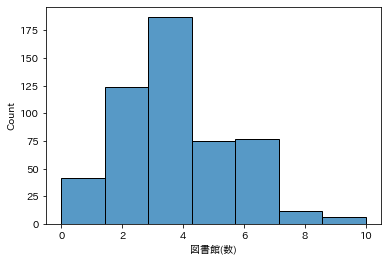

In [19]:
sns.histplot(df_tokyo_district_master['図書館(数)'], bins=7)
plt.show()

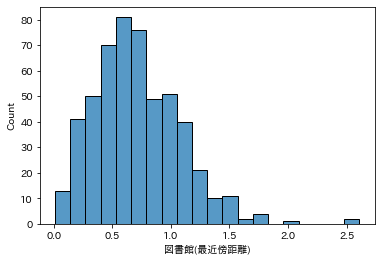

In [20]:
sns.histplot(df_tokyo_district_master['図書館(最近傍距離)'], bins=20)
plt.show()

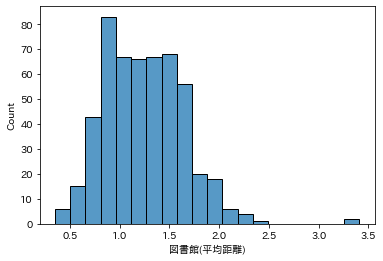

In [21]:
sns.histplot(df_tokyo_district_master['図書館(平均距離)'], bins=20)
plt.show()

In [22]:
def normalize_score(sr_data, high=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    high = score.quantile(0.99)
    low = score.quantile(0.01)
    score[score > high] = high
    score[score < low] = low
    
    return (score - low)/(high - low)

def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

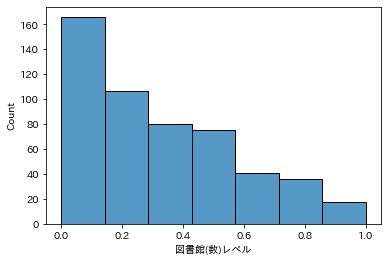

In [23]:
df_tokyo_district_master['図書館(数)レベル'] = normalize_score(df_tokyo_district_master['図書館(数)'])
sns.histplot(df_tokyo_district_master['図書館(数)レベル'], bins=7)
plt.show()

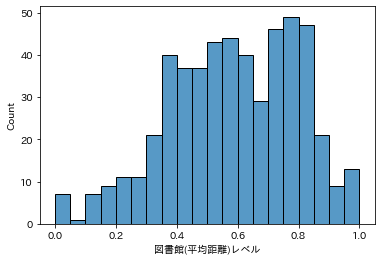

In [24]:
df_tokyo_district_master['図書館(平均距離)レベル'] = normalize_score(df_tokyo_district_master['図書館(平均距離)'], False)
sns.histplot(df_tokyo_district_master['図書館(平均距離)レベル'], bins=20)
plt.show()

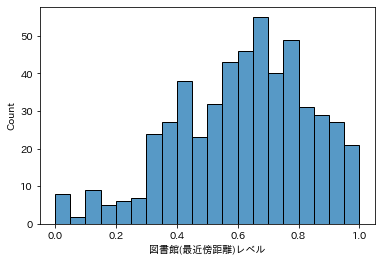

In [25]:
df_tokyo_district_master['図書館(最近傍距離)レベル'] = normalize_score(df_tokyo_district_master['図書館(最近傍距離)'], False)
sns.histplot(df_tokyo_district_master['図書館(最近傍距離)レベル'], bins=20)
plt.show()

In [26]:
score_list = [
    df_tokyo_district_master['図書館(最近傍距離)レベル'] * 1.0,
    df_tokyo_district_master['図書館(平均距離)レベル'] * 0.7,
    df_tokyo_district_master['図書館(数)レベル'] * 0.5,
]
df_tokyo_district_master['_図書館スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_tokyo_district_master['図書館スコア'] = rank_score(df_tokyo_district_master['_図書館スコア'])

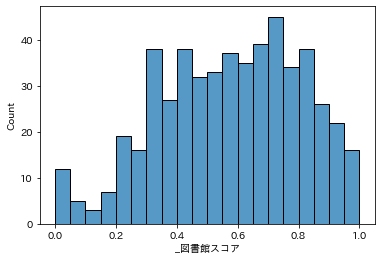

In [27]:
sns.histplot(df_tokyo_district_master['_図書館スコア'], bins=20)
plt.show()

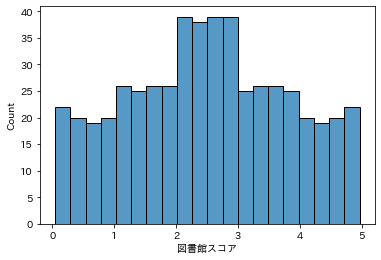

In [28]:
sns.histplot(df_tokyo_district_master['図書館スコア'], bins=20)
plt.show()

In [29]:
df_tokyo_district_master[['市区町村名', '町丁目', '図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)', '図書館スコア']]\
    .to_csv(os.path.join(DIR_NAME, 'library_score.csv'), index=False)

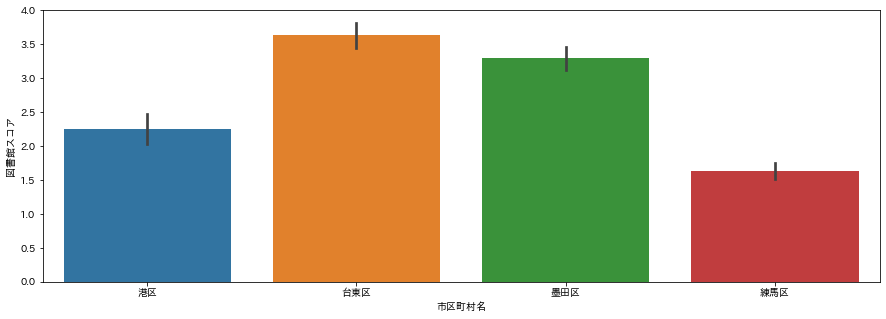

In [30]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='図書館スコア', data=df_tokyo_district_master)
plt.show()

In [31]:
df_library_level = df_tokyo_district_master.copy()
df_library_level['rank'] = df_library_level.groupby('町名')['図書館スコア'].transform('rank', ascending=False)
df_library_level = df_library_level[df_library_level['rank'] == 1].sort_values('図書館スコア', ascending=False)[
    ['市区町村名', '町名', '町丁目', '図書館スコア', '_図書館スコア', '図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)']
].reset_index(drop=True)
print(df_library_level.shape)

(126, 8)


In [32]:
df_library_level.head(20)

,市区町村名,町名,町丁目,図書館スコア,_図書館スコア,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,台東区,千束,千束１丁目,4.968072,1.000000,0.212950,0.479959,6
1,台東区,西浅草,西浅草３丁目,4.968072,1.000000,0.191854,0.427795,8
2,台東区,松が谷,松が谷４丁目,4.968072,1.000000,0.181948,0.353930,6
3,台東区,蔵前,蔵前４丁目,4.968072,1.000000,0.088240,0.719408,7
4,台東区,上野,上野７丁目,4.923372,0.996426,0.207757,0.683835,7
5,墨田区,京島,京島１丁目,4.885057,0.978856,0.017763,0.793960,6
6,墨田区,東駒形,東駒形４丁目,4.872286,0.957805,0.205009,0.862157,7
7,台東区,橋場,橋場１丁目,4.846743,0.955540,0.128811,0.992986,7
8,港区,高輪,高輪１丁目,4.833972,0.955202,0.215805,0.525269,5
9,台東区,浅草橋,浅草橋５丁目,4.821201,0.955193,0.138271,0.813812,6


In [33]:
df_library_level.tail(20)

,市区町村名,町名,町丁目,図書館スコア,_図書館スコア,図書館(最近傍距離),図書館(平均距離),図書館(数)
106,練馬区,旭町,旭町１丁目,2.053001,0.493035,0.704519,1.336185,2
107,練馬区,氷川台,氷川台２丁目,2.027458,0.487644,0.515224,1.660138,2
108,練馬区,高野台,高野台１丁目,2.001916,0.482849,0.775078,1.436133,3
109,港区,西麻布,西麻布３丁目,1.964559,0.478545,0.890642,1.438336,4
110,墨田区,江東橋,江東橋１丁目,1.945402,0.475558,0.931026,1.222100,3
111,練馬区,豊玉南,豊玉南３丁目,1.868774,0.458084,0.604943,1.651261,2
112,練馬区,早宮,早宮４丁目,1.820881,0.448703,0.939449,1.495500,4
113,練馬区,西大泉,西大泉３丁目,1.782567,0.442644,0.754472,1.484097,2
114,練馬区,中村南,中村南１丁目,1.485632,0.400772,0.795646,1.607535,2
115,練馬区,桜台,桜台２丁目,1.447318,0.391891,1.011051,1.472299,3
